# Decision Tree on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Decision Tree</a>

<a href=#feature_importance>Feature Importance</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Decision Tree on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#verify_unbalanced>Verify on Unbalanced Dataset</a>

<a href=#re_train>Re-Train Optimal Tree on Unbalanced data</a>

<a href=#feature_importance_final>Feature Importance on Final Model</a>

<a href=#bottom>Bottom</a>


In [1]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import sem
import pickle

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


In [3]:
# Post-aggregation
def create_dict_types_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    dtype={ 
        'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'has_name_change' : bool,
        'qty_address_mutations_total' :np.float64,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'code_legal_form_group_1':  np.int64,
        'code_legal_form_group_2':  np.int64,
        'SBI_group_1':  np.int64,
        'SBI_group_2':  np.int64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'SBI_has_changed' : bool,
        'unique_id' : object,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_employees'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }
    return dtype

def create_parse_dates_list_aggregated_data():
    # Setting up dictionary of column types for the aggregated dataset
    parse_dates= ['date_month', 'years_in_current_location']
    return parse_dates

def create_basetable(year_list, dir_prefix = ''):
    """ Reads a whole year of data from the already aggregated files and creates basetable """
    dtype = create_dict_types_aggregated_data()
    parse_dates = create_parse_dates_list_aggregated_data()
    basetable = pd.DataFrame()
    for year in year_list:
        full_year_df = pd.DataFrame()
        print('Starting with year: ', year)
        print(dir_prefix)
        blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
        for blob in blob_list:  
            if year in blob.name:
                print('Processing file: ', blob.name)
                with fs.open('graydon-data/' + blob.name) as f:
                    full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates 
                                            )   
                print('The number of rows of the year read is far is: ', full_year_df.shape[0])
        basetable = basetable.append(full_year_df)
    print('The final number of rows of the basetable created is: ', basetable.shape[0])
    return basetable

# Calling it
data_df = create_basetable(year_list = ['2017'], dir_prefix ='03_aggregated')

Starting with year:  2017
03_aggregated
Processing file:  03_aggregated/2017_aggregated.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows of the year read is far is:  1966208
The final number of rows of the basetable created is:  1966208


In [4]:
data_df.shape[0]

1966208

## Check Distribution of Target:
<a href=#top>Top</a>

In [5]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1807074
True       82802
Name: has_relocated_next_year, dtype: int64 
 False    0.919066
True     0.042113
Name: has_relocated_next_year, dtype: float64


In [6]:
sum(data_df.has_relocated_next_year.isna())

76332

In [7]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [8]:
sum(data_df.has_relocated_next_year.isna())

0

In [9]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    1883406
True       82802
Name: has_relocated_next_year, dtype: int64 
 False    0.957887
True     0.042113
Name: has_relocated_next_year, dtype: float64


In [10]:
HTML(DataFrame(data_df).head(10).to_html())

,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,428134.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,37.0,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_428134.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
1,0,803351.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_803351.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
2,0,810695.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_810695.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
3,0,811258.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_811258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
4,0,811333.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_811333.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
5,0,818258.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_818258.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
6,0,823722.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_823722.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
7,0,829630.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_829630.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
8,0,834432.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_834432.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
9,0,834909.0,2017-01-01 00:00:00,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,0_834909.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False


In [11]:
data_df.shape

(1966208, 58)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [12]:
print(data_df.isnull().sum())

id_branch                                                     0
id_company                                                    0
date_month                                                    0
code_sbi_1                                              1885214
has_relocated                                                 0
has_name_change                                               0
delta_qty_employees                                      277433
delta_qty_issued_credit_reports                               0
delta_score_payment_assessment                                0
code_legal_form_has_changed                                   0
SBI_has_changed                                               0
company_age                                               29625
years_since_last_amt_consolidated_operating_result      1839867
years_since_last_amt_consolidated_revenue               1857884
years_since_last_amt_operating_result                   1839867
years_since_last_qty_employees          

In [59]:
features_to_exclude = ('id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       #'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       #'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       #'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       #'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [60]:
len(features_in_model)

37

In [61]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'ratio_revenue_consolidated_revenue',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_employees',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment',
 'variance_score_pd']

In [62]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [63]:
data_to_model.shape

(1966208, 38)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [64]:
data_to_model.isnull().values.any()

True

In [65]:
print(data_to_model.isnull().sum())

has_name_change                             0
delta_qty_issued_credit_reports             0
delta_score_payment_assessment              0
code_legal_form_has_changed                 0
SBI_has_changed                             0
company_age                             29625
ratio_revenue_consolidated_revenue    1857884
qty_green_flags                             0
qty_orange_flags                            0
qty_red_flags                               0
A                                           0
AA                                          0
AAA                                         0
B                                           0
BB                                          0
BBB                                         0
C                                           0
CC                                          0
CCC                                         0
D                                           0
NR                                          0
code_legal_form_group_1           

In [21]:
data_to_model.mean_qty_employees.describe()

count    1.688775e+06
mean     1.143601e+02
std      2.289495e+03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.133740e+05
Name: mean_qty_employees, dtype: float64

Drop rows with NA:

In [46]:
data_to_model.dropna?

In [66]:
#data_to_model.dropna(inplace=True)

data_to_model.dropna(subset=['variance_qty_issued_credit_reports', 'company_age'], inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(1927080, 38)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
data_to_model.isnull().values.any()

True

<a id='dt'></a>
# Decision Tree:

<a href=#top>Top</a>

### Create Test/Train sets

In [68]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [69]:
x_train.shape

(1541664, 37)

In [70]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    1476179
1      65485
Name: has_relocated_next_year, dtype: int64 
 0    0.957523
1    0.042477
Name: has_relocated_next_year, dtype: float64


## Impute Data:

In [53]:
from sklearn.impute import SimpleImputer

In [71]:
SimpleImputer?

In [72]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(x_train)

KeyboardInterrupt: 

In [57]:
# Impute our data, then train
X_train_imp = imp.transform(x_train)
clf00 = tree.DecisionTreeClassifier()
clf00 = clf00.fit(X_train_imp, y_train)

In [58]:
measure_performance(X_train_imp,y_train,clf00, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.984 



In [52]:
clf0 = tree.DecisionTreeClassifier()
clf0.fit(x_train, y_train)  


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [28]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.983 



## Save Model:

<a href=#top>Top</a>

In [29]:
filename = 'models/DT_2017_defaults_unbalanced_MissVal0.sav'
pickle.dump(clf0, open(filename, 'wb'))

In [30]:
print(clf0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


<a href=#top>Top</a>
## Paramater Tuning:

In [21]:
GridSearchCV?

In [39]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [92]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [31]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
y_pred=clf0.predict(x_test)

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[309288,  11032],
       [ 14163,    791]])

In [34]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf0.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9249


In [35]:
y_test.value_counts() / y_test.shape[0]

0    0.955398
1    0.044602
Name: has_relocated_next_year, dtype: float64

In [36]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [37]:
score, auc, kappa

(0.9248525086943813, 0.5416697926505084, 0.02050099453658949)

In [38]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96    320320
           1       0.07      0.05      0.06     14954

   micro avg       0.92      0.92      0.92    335274
   macro avg       0.51      0.51      0.51    335274
weighted avg       0.92      0.92      0.92    335274



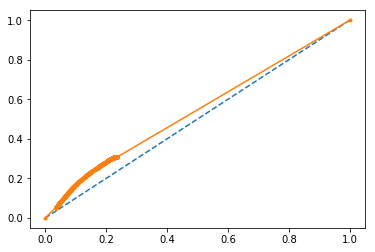

In [39]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance'></a>
# Feature Importance
<a href=#top>Top</a>

In [40]:
len(clf0.feature_importances_)

36

NameError: name 'plt' is not defined

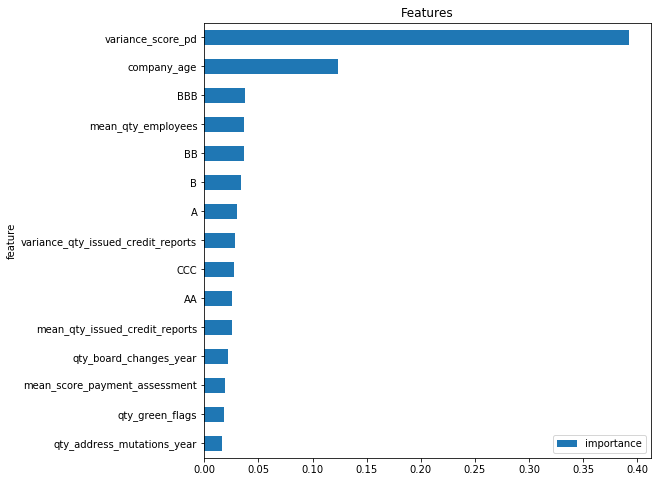

In [41]:
feat_imp = pd.DataFrame({'importance':clf0.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [73]:
train_all = x_train.copy()

In [74]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'ratio_revenue_consolidated_revenue',
       'qty_green_flags', 'qty_orange_flags', 'qty_red_flags', 'A', 'AA',
       'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC', 'D', 'NR',
       'code_legal_form_group_1', 'code_legal_form_group_2', 'SBI_group_1',
       'SBI_group_2', 'is_discontinued_any', 'has_financial_calamity',
       'mean_qty_employees', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'variance_qty_issued_credit_reports',
       'variance_score_payment_assessment', 'variance_score_pd'],
      dtype='object')

In [75]:
train_all['has_relocated_next_year'] = y_train

In [76]:
len(x_train.columns)

37

In [77]:
train_all.shape

(1541664, 38)

In [78]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.957523
1    0.042477
Name: has_relocated_next_year, dtype: float64

In [79]:
# Choose desired class breakdown
fraction_majority = 0.50

In [80]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(65485, 65485, 65485.0, 0.5)

In [81]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    65485
0    65485
Name: has_relocated_next_year, dtype: int64

In [82]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [83]:
df_downsampled.shape

(130970, 38)

## Remove NaNs from Balanced Dataset:

In [84]:
data_to_model = df_downsampled

In [85]:
data_to_model.shape

(130970, 38)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [86]:
data_to_model.isnull().values.any()

True

In [87]:
print(data_to_model.isnull().sum())

has_name_change                            0
delta_qty_issued_credit_reports            0
delta_score_payment_assessment             0
code_legal_form_has_changed                0
SBI_has_changed                            0
company_age                                0
ratio_revenue_consolidated_revenue    126554
qty_green_flags                            0
qty_orange_flags                           0
qty_red_flags                              0
A                                          0
AA                                         0
AAA                                        0
B                                          0
BB                                         0
BBB                                        0
C                                          0
CC                                         0
CCC                                        0
D                                          0
NR                                         0
code_legal_form_group_1                    0
code_legal

Drop rows with NA:

In [59]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(158662, 36)


In [94]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Decision Tree on Re-balanced data

<a href=#top>Top</a>

In [88]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [53]:
from sklearn.impute import SimpleImputer

In [71]:
SimpleImputer?

In [89]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(x_re_train)

In [92]:
# Impute our data, then train
X_train_imp = imp.transform(x_re_train)


In [93]:
clf = tree.DecisionTreeClassifier()

clf.fit(X_train_imp, y_re_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [95]:
# Train accuracy:
measure_performance(X_train_imp,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.916 



In [97]:
imp_test = imp.fit(x_re_test)

In [98]:
# Impute our data, then train
X_test_imp = imp.transform(x_re_test)


In [99]:
# Test accuracy:
measure_performance(X_test_imp,y_re_test,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.577 



## Write out model:

In [100]:
filename = 'models/DT_2017defaults_balanced_MissVal.sav'
pickle.dump(clf, open(filename, 'wb'))

## Tuning:

In [104]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [69]:
tree.DecisionTreeClassifier?

In [106]:
from sklearn.metrics import cohen_kappa_score, make_scorer

kappa_scorer = make_scorer(cohen_kappa_score)

parameters = {'max_depth':range(5,25), 'min_samples_split':[5,10,15,20], 'min_samples_leaf':[2,3,5]}
clfKappa = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, scoring=kappa_scorer)
#clfKappa.fit(X=x_re_train, y=y_re_train)
clfKappa.fit(X=X_train_imp, y=y_re_train)
clfDT_Kappa = clfKappa.best_estimator_
print (clfKappa.best_score_, clfKappa.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.23717361010165847 {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [107]:
filename = 'models/DT_2017md12__mss20_msl5_balanced_MissVal.sav'
pickle.dump(clfDT_Kappa, open(filename, 'wb'))

In [108]:
# Grid searched DT accuracy:
measure_performance(X_train_imp,y_re_train, clfDT_Kappa, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.635 



## Accuracy on Test Set:

<a href=#top>Top</a>

In [109]:
y_re_pred=clf.predict(X_test_imp)

In [110]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[9192, 7113],
       [6749, 9689]])

In [105]:
#y_re_pred=clfDT_Kappa.predict(X_test_imp)
y_re_pred=clf.predict(X_test_imp)

score=metrics.accuracy_score(y_re_test, y_re_pred)


# Get probabilities
y_re_probs = clf.predict_proba(X_test_imp)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

score, auc, kappa

(0.5766423357664233, 0.5829924316917902, 0.15319422297047502)

In [112]:
y_re_pred=clfDT_Kappa.predict(X_test_imp)

score=metrics.accuracy_score(y_re_test, y_re_pred)


# Get probabilities
y_re_probs = clfDT_Kappa.predict_proba(X_test_imp)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

score, auc, kappa

(0.621140396420609, 0.6749184235493864, 0.2418185061330429)

In [113]:
print(cr)

              precision    recall  f1-score   support

           0       0.64      0.55      0.59     16305
           1       0.61      0.70      0.65     16438

   micro avg       0.62      0.62      0.62     32743
   macro avg       0.62      0.62      0.62     32743
weighted avg       0.62      0.62      0.62     32743



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


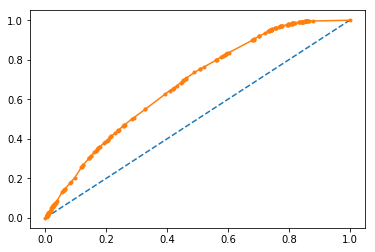

In [114]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='verify_unbalanced'></a>
## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [115]:
y_re_pred_unbalance=clfDT_Kappa.predict(x_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [68]:
y_re_pred_unbalance.shape

(385416,)

In [69]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.04313780434647238, 0.9568621956535276)

In [70]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.47176038358552835, 0.5282396164144716)

In [71]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[198526, 170264],
       [  5066,  11560]])

In [72]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clfDT_Kappa.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [73]:
score, auc, kappa

(0.5450889428565499, 0.6683904392543888, 0.04067028205988632)

In [74]:
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.54      0.69    368790
           1       0.06      0.70      0.12     16626

   micro avg       0.55      0.55      0.55    385416
   macro avg       0.52      0.62      0.41    385416
weighted avg       0.94      0.55      0.67    385416



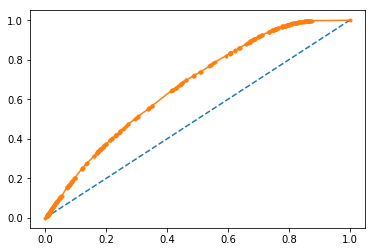

In [75]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='re_train'></a>
# Re-Train Optimal Tree on Unbalanced data 
<a href=#top>Top</a>

In [76]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [77]:
tree.DecisionTreeClassifier?

In [78]:
#'min_samples_leaf': 5, 'max_depth': 12, 'min_samples_split': 20

clf1 = tree.DecisionTreeClassifier(max_depth=12, min_samples_split=20, min_samples_leaf=5)
clf1.fit(x_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [79]:
measure_performance(x_train,y_train,clf1, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.958 



In [80]:
y_predII=clf1.predict(x_test)

In [81]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predII)
cnf_matrix

array([[368712,     78],
       [ 16609,     17]])

In [82]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf1.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9567


In [83]:
score=metrics.accuracy_score(y_test, y_predII)

# Get probabilities
y_probs = clf1.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [84]:
score, auc, kappa

(0.9567039251094921, 0.6747081663118744, 0.02750563310873655)

In [85]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96    368790
           1       0.07      0.05      0.06     16626

   micro avg       0.93      0.93      0.93    385416
   macro avg       0.52      0.51      0.51    385416
weighted avg       0.92      0.93      0.92    385416



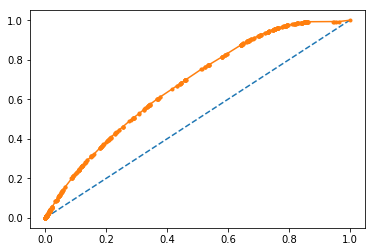

In [86]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill

pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance2'></a>
## Feature Importance
<a href=#top>Top</a>

NameError: name 'plt' is not defined

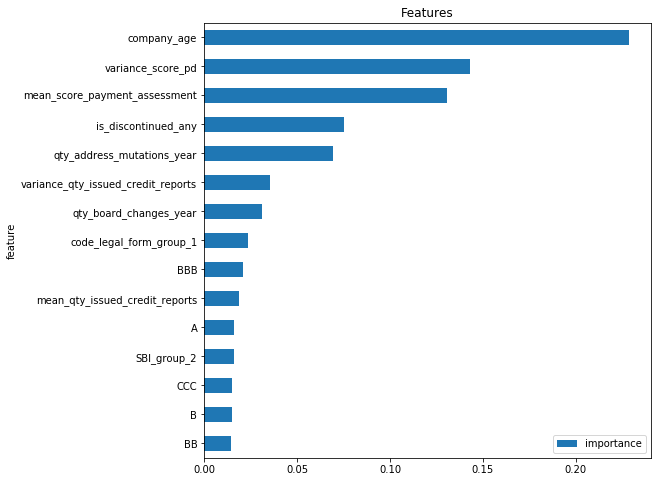

In [87]:
feat_imp = pd.DataFrame({'importance':clf1.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a href=#top>Top</a>
# Feature Importance of Final Model:
<a id='feature_importance_final'></a>

In [116]:
importances = clfDT_Kappa.feature_importances_

In [117]:
len(importances)

37

NameError: name 'plt' is not defined

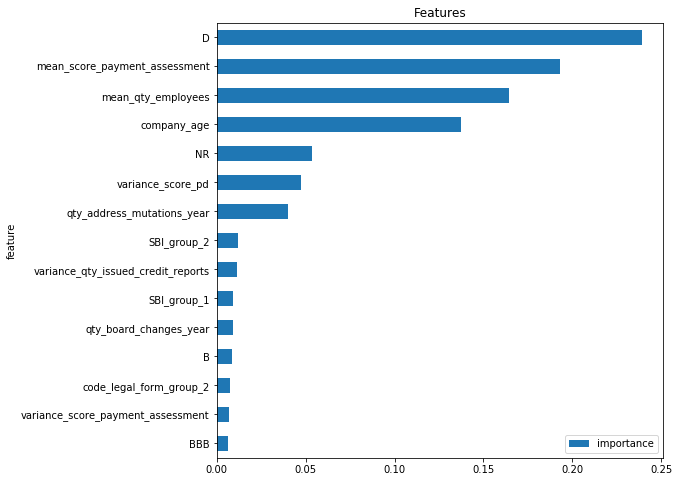

In [118]:
feat_imp = pd.DataFrame({'importance':importances})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

<a id='bottom'></a>

<a href=#top>Top</a>
# End